In [1]:
%load_ext autoreload
%autoreload 2
import sys
#sys.path.append('..')

In [2]:
sys.path.append('../')
sys.path.append('../src/')
print(sys.path)

['C:\\Users\\Oliver\\Documents\\Academic\\Applied data analysis and machine learning\\Projects\\FYS-STK4155-project2\\notebooks', 'c:\\users\\oliver\\appdata\\local\\programs\\python\\python39\\python39.zip', 'c:\\users\\oliver\\appdata\\local\\programs\\python\\python39\\DLLs', 'c:\\users\\oliver\\appdata\\local\\programs\\python\\python39\\lib', 'c:\\users\\oliver\\appdata\\local\\programs\\python\\python39', '', 'c:\\users\\oliver\\appdata\\local\\programs\\python\\python39\\lib\\site-packages', 'c:\\users\\oliver\\appdata\\local\\programs\\python\\python39\\lib\\site-packages\\win32', 'c:\\users\\oliver\\appdata\\local\\programs\\python\\python39\\lib\\site-packages\\win32\\lib', 'c:\\users\\oliver\\appdata\\local\\programs\\python\\python39\\lib\\site-packages\\Pythonwin', 'c:\\users\\oliver\\appdata\\local\\programs\\python\\python39\\lib\\site-packages\\IPython\\extensions', 'C:\\Users\\Oliver\\.ipython', '../', '../src/']


In [166]:
from src.data.create_dataset import *
from src.visualization.visualize import *
from sklearn.model_selection import  train_test_split
from sklearn.preprocessing import StandardScaler

In [167]:
from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression
cancer = load_breast_cancer()

In [ ]:
cancer.data.shape

In [ ]:
cancer.target

Ok so data looks fairly simple, it's a design matrix with 40 features and 569 samples. We simply input it to the model like normal. So the inputs are continuous, but the target data, i.e the z data are 0's and 1's. So we're esentially creating a linear function that produces a result which is continuous and is then fed into sigmoid, which then classifies, or simply gives probability.

In [88]:
X_train, X_test, z_train, z_test = train_test_split(cancer.data,cancer.target)
z_train.shape

(426,)

In [168]:
X_train, X_test, z_train, z_test = train_test_split(cancer.data,cancer.target)
Xscaler = StandardScaler().fit(X_train)
#zscaler = StandardScaler().fit(z_train)

X_train = Xscaler.transform(X_train)
X_test = Xscaler.transform(X_test)
#z_train = zscaler.transform(z_train)


In [207]:
from src.modelling.nn import NeuralNetwork
nn = NeuralNetwork(hidden_activation = 'relu',output_activation = 'sigmoid', loss_func = 'cross_entropy',
                   momentum = 0.5,w_init='glorot',batch_size = 32,n_epochs = 1000,val_fraction=0.1)
nn.fit(X_train,z_train.reshape(-1,1))
#nn.predict(cancer.data)

426
(383, 1)


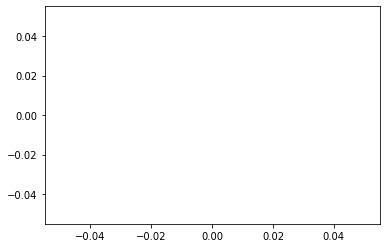

In [211]:
plt.plot(nn.val_loss)
#plt.plot(nn.loss)

In [188]:
(nn.layers[0].weights.ravel()@nn.layers[0].weights.ravel())

36.89962572574761

So overflow when just feeding data un standardized directly into my network. What about keras or sklearn?

In [ ]:
from tensorflow.keras import initializers
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

#initializer = tf.keras.initializers.RandomNormal(mean=0., stddev=1.)
initializer = tf.keras.initializers.GlorotUniform()
init_b = tf.keras.initializers.Constant(value=0.001)


model = keras.Sequential()

model.add(layers.Dense(100, kernel_initializer=initializer,bias_initializer= init_b, input_shape=(30,)))
model.add(layers.Activation('relu'))

model.add(layers.Dense(50, kernel_initializer=initializer,bias_initializer= init_b))
model.add(layers.Activation('relu'))

model.add(layers.Dense(1, kernel_initializer=initializer,bias_initializer= init_b))
model.add(layers.Activation('sigmoid'))

opt = keras.optimizers.SGD(learning_rate=0.01,momentum=0.5)
model.compile(loss='binary_crossentropy', optimizer=opt)

In [ ]:
model.fit(X_train,z_train,batch_size = 32, epochs=1000,verbose=0)

In [ ]:
model.predict(cancer.data)

In [ ]:
model.get_layer(index=2).get_weights()[1]

In [ ]:
model.summary()

In [ ]:
from sklearn.neural_network import MLPClassifier

nn_sk = MLPClassifier(max_iter = 1000, hidden_layer_sizes=(100,50),
                     activation = 'relu',solver='sgd',
                     learning_rate_init=0.01,batch_size = 32,momentum= 0.5,alpha=0.0,tol=0)
nn_sk.fit(X_train,z_train)

In [ ]:
#print(nn_sk.predict_proba(X_train))
print('\n')
print(nn_sk.coefs_[-1].shape)
print(nn_sk.classes_)
print(nn_sk.get_params())
nn_sk.predict(X_train)

In [ ]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import OneHotEncoder
y = to_categorical(cancer.target)
y2 = OneHotEncoder().fit_transform(cancer.target.reshape(-1,1))
print(y.shape)
print(y2.shape)

In [ ]:
cancer.target.shape

In [ ]:
len(cancer.target.shape)

In [ ]:
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
y3 = lb.fit_transform(cancer.target)
y3[0]

So what might be the case is simply that sklearn and keras implements methods to avoid numerical instabilities so that computation can continue. With  inf values here and there an activation with sigmoid will simply result in 1, or minus inf will result in 0. So perhaps somehow the probability outputted, not being 1 btw, has something to do either with the distribution of the data set, or that it magically somehow converges to 0.62 something. Perhaps something to do with e?

So the weights of sklearn and keras are not infinite, they are something. But perhaps those are the weights that reached the limit of maximum number in terms of computational stability?

Either way, turned out that standardizing the data helped majorly in avoiding exploding gradient.

In [209]:
from src.modelling.logreg import SGD_logreg

logreg = SGD_logreg(n_epochs=10000)
logreg.fit(X_train,z_train.reshape(-1,1))

426
(383, 1)


In [111]:
logreg.score(X_train,z_train.reshape(-1,1))


1.0

Ah so if SGD_logreg inherits from SGD_linreg that inherits from SGD_optimizer, it does indeed get the fit function, however it inherits the fit function SGD_linreg inherited, which uses SGD_linregs predict.

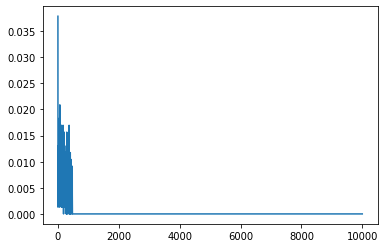

In [210]:
import matplotlib.pyplot as plt
#plt.plot(logreg.scores)
plt.plot(logreg.loss)

So when pumping up n epochs, we see that the model does improve on test data, however stagnates at 0.96, and doesn't ever decrease. I guess it's hard to overfit now, because we have the features that we have and model complexity can't increase.

In [114]:
logreg.score(X_test,z_test.reshape(-1,1))

0.965034965034965

In [65]:
logreg.beta

array([[ 0.05235891],
       [-0.01117482],
       [-0.04907666],
       [ 0.05323615],
       [-0.02788537],
       [ 0.13091652],
       [-0.09944011],
       [-0.00267761],
       [ 0.01176267],
       [-0.01108023],
       [-0.02716792],
       [ 0.00913157],
       [ 0.11177889],
       [-0.19197075],
       [ 0.02090135],
       [-0.02746825],
       [ 0.06040906],
       [-0.09146193],
       [ 0.01738799],
       [ 0.04251909],
       [-0.10929564],
       [-0.01323301],
       [-0.04853388],
       [ 0.0517787 ],
       [-0.00571401],
       [-0.03386452],
       [-0.00030942],
       [ 0.03188995],
       [-0.02846331],
       [-0.0320937 ]])

In [212]:
from sklearn.linear_model import LogisticRegression
#X_train, X_test, z_train, z_test = train_test_split(cancer.data,cancer.target,random_state=0)
print(X_test.shape)
print(X_train.shape)
print(z_test.shape)
print(z_train.shape)
logreg_sk = LogisticRegression(solver='lbfgs')
logreg_sk.fit(X_train,z_train)
logreg_sk.score(X_test,z_test)

(143, 30)
(426, 30)
(143,)
(426,)


c:\users\oliver\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.972027972027972

0.40350877192982454

Ok nice, so all methods seems to be working. A question is now, where do I go from here? Perhaps a train test result graph during training is useful? Unclear if that is normal. Though should be able to see if I reach a region of overfit at least. Several ways to do that. One can measure loss of a validation and train set during training, hm, or that's gonna be rather slow.

So how to do overfit analysis? So one usually start with lr and lambda tuning, and then move on to other parameters. So how to see if num epochs gets too much? I guess I should have early stopping implemente. Because if I first tune lr and lmb without regards for overfitting then if I change n_epochs, the lr does perhaps not give a good answer anymore. Perhaps by implementing early stopping one would get the best 'test score' on every lr and lmb one tries. Although, I theory you would like the cost function to converge to a good solution, meaning plentiful epochs and still no overfit. So perhaps better aim many epochs, and then continuou search

If I capture loss during training I can plot the graph and see how many epochs it took to somewhat converge.

In [152]:
import numpy as np
a = np.asarray([1,2,3])
b = np.asarray([0.5,0.5,0.5])
(1-a)

array([ 0, -1, -2])